# Milestone 4

#### Objective:

 - Audit a model for bias when the protected class is not available.

#### Workflow:

 - Introduction
 - Set up problem
 - Load data and display primary and secondary sets
 - Load model to audit for bias
 - Train model from proxy variables to predict the protected class
 - Assess the model bias
 - Report your findings

#### Importance to Project:

 - Very often, protected class information is not available when you are auditing for bias or removing bias.  
 - In these cases, the task becomes much more challenging. 
 - You might not have access to the protected class information either because you can only see the model itself and not the underlying data, or because even the original creators don't know the protected class status of each row. 
 - While auditing or mitigating bias without direct access to the protected class introduces a level of uncertainty, we can still reach some conclusions about biased models, but must be open about the uncertainty.
 - The most powerful techniques are beyond the scope of this milestone. However, knowing some baseline techniques can be helpful in easy cases and can help guide a decision whether to pursue a more in-depth audit.

#### Resources:

 - You should be able to proceed with this milestone without any additional resources. However, the following resources will provide useful context and more information.
  - https://arxiv.org/pdf/1906.00285.pdf and accompanying video https://www.youtube.com/watch?v=z-ZI1VoA-O0]. Milestone 4 tracks this paper closely - the main difference is in methodology.
  - https://arxiv.org/pdf/1811.11154.pdf - This paper demonstrates some of the weaknesses of proxy-based approaches
  - https://github.com/cfpb/proxy-methodology - This repository contains the BISG proxy methodology
  - https://amstat.tandfonline.com/doi/full/10.1080/2330443X.2018.1427012 - This paper explains the BISG proxy methodology

## Introduction

We can still assess algorithmic fairness when the protected class is unobserved, provided we have some way to deduce the protected class from the available data. The most famous real-world example of this is the BISG proxy, which uses a Naive Bayes model to predict race membership based on name and zipcode. As [Chen et al](https://arxiv.org/pdf/1811.11154.pdf) note, "This methodology notably supported a $98 million fine against a major auto loan lender".

While the BISG proxy methodology is still used and developed, recent scholarship in machine fairness demonstrates some serious shortcomings and some new directions for modelling without access to protected class data. The fundamental issue is that proxy models, unless highly accurate, could skew the audit. For instance, [Chen et al](https://arxiv.org/pdf/1811.11154.pdf) showed the BISG methodology has been shown to overestimate true disparities. In summary, we need to exercise great care when building proxy models and imputing protected class data.

In terms of new directions for assessing algorithmic fairness when the protected class is unobserved, an interesting paper released this year entitled ["Assessing Algorithmic Fairness with Unobserved Protected Class Using Data Combination"](https://arxiv.org/pdf/1906.00285.pdf) describes a methodology for estimating confidence intervals for bias metrics. While the methodology is too complex to review here, in the course of this milestone it will become clear why confidence intervals are so useful. It is well worth considering for any bias audit where the protected class is unavailable.

Regardless of the chosen methodology, the general setup requires the following datasets:
 - a primary dataset, which contains input variables to the model and the model's final prediction
 - a secondary dataset, which contains some proxy variables which overlap with the primary dataset, and does contain the protected class labels
     
An example of a primary set and secondary set in a lending context with potential racial bias can be found below (proxy variables are surname and zipcode, as in BISG, and they can be found in both the primary and secondary sets)

## Setting up the problem

In our example, you are asked by the WHO to evaluate bias in a model which determines personalized warfarin dosage. A similar model built on the same dataset has already been audited using state-of-the-art partial identification sets in a recent paper by Kallus, Mao and Zhou. We will be using a simpler methodology.

Warfarin is the world's most common anticoagulant, but the correct dosage for the desired effect changes significantly from person to person. Too little warfarin will fail to produce a coagulant effect, while too much warfarin can cause dangerous bleeding, stroke and death. 

In these circumstances, dosage by trial and error is dangerous, so the medical community has built models to predict the ideal warfarin dosage. These models can be found in section 8.2 of ["Assessing Algorithmic Fairness with Unobserved Protected Class Using Data Combination"](https://arxiv.org/pdf/1906.00285.pdf). The makers of the models note that genetic factors correlated with race are predictive of the outcome, so we can expect dosage and dosage prediction to differ by race. In this scenario, the WTO has asked you to audit the model's bias with respect to race. 

For this audit, we are going to simulate an environment where race data is not available. To audit the model's bias with respect to race, one method is to train a proxy model on a primary set as described above. Instead of approaching the problem blindly, you are given two categories of columns: genetic features, and medication features. 

## Load libraries and dataset

 - The following code will load all necessary libraries and data. 
 - The code should load:
   - A primary and secondary dataset
   - An initial model
   - A set of genotype columns and a set of medication columns, which can be each used to train a proxy
   - Columns initially used to train the model
   - A true positive rate helper function

In [1]:
import pandas as pd
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import sklearn

In [2]:
%run "./Milestone 4 declarations.ipynb"

C:\Users\zbenm\EMAN2\envs\bias-project\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
C:\Users\zbenm\EMAN2\envs\bias-project\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.23.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [3]:
print('Primary dataset')
display(primary)
print('Secondary dataset')
display(secondary)
print('Confirm model loaded')
print('Genotype columns:\n', genotype_columns,'\n\n')
print('Medication columns:\n', medication_columns,'\n\n')
print('Model training columns:\n', training_columns,'\n\n')
print(help(tpr))
model

Primary dataset


,Unnamed: 0,Project Site,Age,Height (cm),Weight (kg),Diabetes,Congestive Heart Failure and/or Cardiomyopathy,Valve Replacement,Aspirin,Acetaminophen or Paracetamol (Tylenol),...,VKORC1 QC genotype: -4451 C>A (861); Chr16:31018002; rs17880887; A/C,CYP2C9 consensus,VKORC1 -1639 consensus,VKORC1 497 consensus,VKORC1 1173 consensus,VKORC1 1542 consensus,VKORC1 3730 consensus,VKORC1 2255 consensus,VKORC1 -4451 consensus,target
0,1163,3,75.0,150.114,54.0,-1.0,0.0,0.0,-1.0,-1.0,...,3.0,0.0,0.0,3.0,2.0,0.0,2.0,2.0,3.0,False
1,891,3,65.0,172.974,58.0,-1.0,0.0,0.0,-1.0,-1.0,...,3.0,0.0,1.0,3.0,1.0,1.0,1.0,1.0,3.0,False
2,5377,20,75.0,175.260,82.0,-1.0,0.0,0.0,1.0,-1.0,...,3.0,0.0,3.0,1.0,1.0,1.0,1.0,1.0,3.0,False
3,501,2,65.0,-1.000,101.0,0.0,0.0,0.0,1.0,0.0,...,3.0,4.0,3.0,2.0,3.0,1.0,3.0,3.0,3.0,False
4,2795,8,55.0,154.000,64.0,0.0,0.0,1.0,0.0,0.0,...,2.0,5.0,0.0,2.0,2.0,0.0,2.0,2.0,2.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1258,1875,5,55.0,186.182,110.5,0.0,0.0,1.0,1.0,0.0,...,3.0,0.0,1.0,1.0,3.0,1.0,1.0,3.0,2.0,False
1259,2766,8,65.0,156.000,43.0,0.0,0.0,1.0,0.0,0.0,...,3.0,0.0,0.0,3.0,2.0,3.0,2.0,3.0,3.0,False
1260,3514,11,65.0,152.400,75.5,1.0,0.0,0.0,0.0,1.0,...,3.0,0.0,2.0,2.0,3.0,3.0,0.0,3.0,2.0,True
1261,215,1,45.0,172.720,102.5,-1.0,-1.0,-1.0,0.0,-1.0,...,3.0,0.0,2.0,2.0,3.0,2.0,0.0,3.0,3.0,True


Secondary dataset


,Unnamed: 0,Cyp2C9 genotypes,Genotyped QC Cyp2C9*2,Genotyped QC Cyp2C9*3,Combined QC CYP2C9,VKORC1 genotype: -1639 G>A (3673); chr16:31015190; rs9923231; C/T,VKORC1 QC genotype: -1639 G>A (3673); chr16:31015190; rs9923231; C/T,VKORC1 genotype: 497T>G (5808); chr16:31013055; rs2884737; A/C,VKORC1 QC genotype: 497T>G (5808); chr16:31013055; rs2884737; A/C,VKORC1 genotype: 1173 C>T(6484); chr16:31012379; rs9934438; A/G,...,Cerivastatin (Baycol),Amiodarone (Cordarone),Carbamazepine (Tegretol),Phenytoin (Dilantin),Rifampin or Rifampicin,Sulfonamide Antibiotics,Macrolide Antibiotics,Anti-fungal Azoles,"Herbal Medications, Vitamins, Supplements",Race (OMB)
0,5360,4.0,1.0,0.0,1.0,2.0,2.0,2.0,2.0,0.0,...,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,White
1,709,0.0,3.0,3.0,6.0,0.0,3.0,3.0,3.0,2.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,Asian
2,65,0.0,3.0,3.0,6.0,2.0,3.0,2.0,3.0,3.0,...,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,White
3,3723,0.0,3.0,3.0,6.0,2.0,3.0,3.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,White
4,5470,0.0,3.0,3.0,6.0,3.0,3.0,3.0,3.0,0.0,...,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,White
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2520,3791,0.0,3.0,3.0,6.0,2.0,3.0,3.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Black or African American
2521,3650,0.0,3.0,3.0,6.0,1.0,3.0,1.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,White
2522,3559,0.0,3.0,3.0,6.0,2.0,3.0,2.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,White
2523,5534,4.0,3.0,3.0,6.0,3.0,3.0,3.0,3.0,1.0,...,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,White


Confirm model loaded
Genotype columns:
 ['Cyp2C9 genotypes', 'Genotyped QC Cyp2C9*2', 'Genotyped QC Cyp2C9*3', 'Combined QC CYP2C9', 'VKORC1 genotype: -1639 G>A (3673); chr16:31015190; rs9923231; C/T', 'VKORC1 QC genotype: -1639 G>A (3673); chr16:31015190; rs9923231; C/T', 'VKORC1 genotype: 497T>G (5808); chr16:31013055; rs2884737; A/C', 'VKORC1 QC genotype: 497T>G (5808); chr16:31013055; rs2884737; A/C', 'VKORC1 genotype: 1173 C>T(6484); chr16:31012379; rs9934438; A/G', 'VKORC1 QC genotype: 1173 C>T(6484); chr16:31012379; rs9934438; A/G', 'VKORC1 genotype: 1542G>C (6853); chr16:31012010; rs8050894; C/G', 'VKORC1 QC genotype: 1542G>C (6853); chr16:31012010; rs8050894; C/G', 'VKORC1 genotype: 3730 G>A (9041); chr16:31009822; rs7294;  A/G', 'VKORC1 QC genotype: 3730 G>A (9041); chr16:31009822; rs7294;  A/G', 'VKORC1 genotype: 2255C>T (7566); chr16:31011297; rs2359612; A/G', 'VKORC1 QC genotype: 2255C>T (7566); chr16:31011297; rs2359612; A/G', 'VKORC1 genotype: -4451 C>A (861); Chr16:3101

RandomForestClassifier(random_state=42)

## Given the supplied training columns, use the model to predict warfarin dosage for the primary set

 - If loaded properly, you can just use model.predict on the training columns of the primary dataset

In [8]:
predictions = model.predict(primary[training_columns])

In [9]:
from sklearn.metrics import classification_report

In [11]:
print(classification_report(primary['target'], predictions))

              precision    recall  f1-score   support

       False       0.80      0.87      0.84       876
        True       0.64      0.52      0.57       387

    accuracy                           0.76      1263
   macro avg       0.72      0.69      0.70      1263
weighted avg       0.75      0.76      0.76      1263



## Train a proxy model on the secondary set to impute the missing protected class data

 - The overall goal of this section is to train some proxy models to predict race.
 - The only requirement for a proxy model is that its inputs are available in both primary and secondary sets, and that it predicts the column we are trying to impute (race). A simple Random Forest or LightGBM classifier, trained on the secondary set, will suffice. **Make sure you hold out a test portion of the secondary set to test performance.**
 - Based on the column lists approved by domain experts (medication_columns, genotype_columns), three models are possible: one model uses medication_columns to predict race, one uses genotype_columns to predict race, and one uses both.
 - Create a confusion matrix showing each proxy model's performance on the same test set
 - Conclude which model has the best performance. We will use it going forward.

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(secondary[medication_columns + genotype_columns],
                                                    secondary['Race (OMB)'])

In [18]:
X_train.shape, X_test.shape

((1893, 44), (632, 44))

In [15]:
from sklearn.ensemble import RandomForestClassifier

In [16]:
rf1 = RandomForestClassifier().fit(X_train[medication_columns], y_train)

In [21]:
rf1_predictions = rf1.predict(X_test[medication_columns]); print(classification_report(y_test, rf1_predictions))

                           precision    recall  f1-score   support

                    Asian       0.78      0.98      0.87       211
Black or African American       0.61      0.40      0.48        63
                    White       0.90      0.82      0.86       358

                 accuracy                           0.83       632
                macro avg       0.76      0.73      0.74       632
             weighted avg       0.83      0.83      0.82       632



In [22]:
rf2 = RandomForestClassifier().fit(X_train[genotype_columns], y_train)

In [24]:
rf2_predictions = rf2.predict(X_test[genotype_columns]); print(classification_report(y_test, rf2_predictions))

                           precision    recall  f1-score   support

                    Asian       0.97      0.97      0.97       211
Black or African American       0.67      0.68      0.68        63
                    White       0.93      0.93      0.93       358

                 accuracy                           0.92       632
                macro avg       0.86      0.86      0.86       632
             weighted avg       0.92      0.92      0.92       632



In [25]:
rf3 = RandomForestClassifier().fit(X_train[medication_columns + genotype_columns], y_train)

In [27]:
rf3_predictions = rf3.predict(X_test[medication_columns + genotype_columns]); print(classification_report(y_test, rf3_predictions))

                           precision    recall  f1-score   support

                    Asian       0.99      0.98      0.98       211
Black or African American       0.73      0.68      0.70        63
                    White       0.93      0.95      0.94       358

                 accuracy                           0.93       632
                macro avg       0.88      0.87      0.88       632
             weighted avg       0.93      0.93      0.93       632



## Add a race column to the primary dataset by using the proxy model with the best performance

Since the proxy columns are present in the primary and secondary sets, you can now predict the race of each row in the primary dataset. Simply run proxy_model.predict on the column set you chose in the primary set.






In [28]:
primary['race'] = rf3.predict(primary[medication_columns + genotype_columns])

##  Assess the model bias with the best proxy

In a real-world context, we will usually have some idea of what specific bias metrics we want to measure and report back on. In this case, we can take some guidance from ["Assessing Algorithmic Fairness with Unobserved Protected Class Using Data Combination"](https://arxiv.org/pdf/1906.00285.pdf) paper and look to the bias metrics they investigated for this dataset. The authors in that case study were interested in the distribution of high dosage recommendations by race ("demographic disparity", see section 8.2 of ["Assessing Algorithmic Fairness with Unobserved Protected Class Using Data Combination"](https://arxiv.org/pdf/1906.00285.pdf)), and the distribution of true positive rates by race ("equal opportunity difference").

 - Grouping the dataset by race, observe how the high dosage model's recommendations are distributed, and how they compare to the ground truth ('target'). Is there a disparity in dosage recommendations by race (**disparate impact**)?
 - Using the tpr helper function, compare the true positive rates for each race. Is there a disparity in TPRs (**equal opportunity difference**)? 

In [34]:
primary['prediction'] = model.predict(primary[training_columns])

In [50]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [51]:
def plot_confusion_matrix(y_true,y_pred, return_percentage=False):
    
    """ (Series, Series, bool) -> None
    Plot a confusion matrix"""
    
    cm = confusion_matrix(y_true,y_pred,labels=[1,0])
    
    if return_percentage:
        cm = np.round(np.asarray(cm)/(np.asarray(cm).sum()),3)

    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Greens',fmt='g'); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['positive', 'negative']); ax.yaxis.set_ticklabels(['positive', 'negative']);
    plt.show()

Asian
----------
              precision    recall  f1-score   support

       False       0.91      0.95      0.93       353
        True       0.39      0.26      0.31        43

    accuracy                           0.88       396
   macro avg       0.65      0.60      0.62       396
weighted avg       0.86      0.88      0.86       396



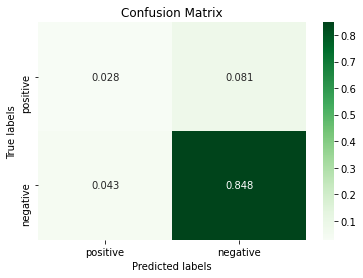


Black or African American
----------
              precision    recall  f1-score   support

       False       0.58      0.35      0.44        51
        True       0.62      0.80      0.70        66

    accuracy                           0.61       117
   macro avg       0.60      0.58      0.57       117
weighted avg       0.60      0.61      0.58       117



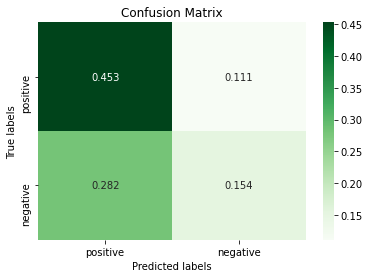


White
----------
              precision    recall  f1-score   support

       False       0.74      0.87      0.80       472
        True       0.69      0.49      0.57       278

    accuracy                           0.73       750
   macro avg       0.71      0.68      0.69       750
weighted avg       0.72      0.73      0.72       750



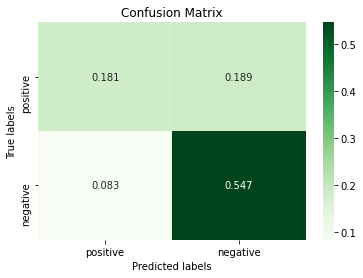

In [52]:
for race, df in primary.groupby('race'):
    print(race)
    print('-' * 10)
    print(classification_report(df['target'], df['prediciton']))
    plot_confusion_matrix(df['target'], df['prediciton'], return_percentage=True)
    print()

In [36]:
for race, _ in primary.groupby('race'):
    print(race)
    print('-' * 10)
    print('tpr', tpr(primary, race))

Asian
----------
tpr ('True positive rate for Asian: 0.2558139534883721', 'True positive rate for non-Asian: 0.5494186046511628', 'Disparity in True positive rate: -0.29360465116279066')
Black or African American
----------
tpr ('True positive rate for Black or African American: 0.803030303030303', 'True positive rate for non-Black or African American: 0.45794392523364486', 'Disparity in True positive rate: 0.34508637779665813')
White
----------
tpr ('True positive rate for White: 0.4892086330935252', 'True positive rate for non-White: 0.5871559633027523', 'Disparity in True positive rate: -0.09794733020922713')


## Report on intermediate findings

 - Were the high dosage recommendation rates roughly equivalent across races, or was there a substantial difference indicating disparate impact?
 - Were the true positive rates roughly equivalent across races, or was there a substantial difference indicating equal opportunity difference?
 - What are some reasons to be cautious about true positive rates calculated with the help of a proxy model?
 - What actions could be taken by data scientists or clinicians as a result of your findings?

- high dosage is recommended above with higher rates for black patients, and with lower rates to asian patients.
- the true positive rates, also agree with above (high for black, low for asian).
- We need to make sure the proxy model does not introduce bias itself, and so the proxy model should be audited first.
- It is important to understand if the model we're using is doing the right thing, given potential differences among etnicity groups. We may also learn something new, about life style that is followed by one group more, that leads to positive or negative health conditions at a certain age (and publish recommendations). If no good explanation found, it is worth exploring what data was fed into the model, and wheather the data contains historical bias, that can potentailly addressed by methods we learned in previous milestone (preprocessing, post processing, etc.), to achieve better results to match the blind medial best practices.

##  Assess the model bias using race imputation from other proxies
 - Since we have other proxy models available, we can gain a little more confidence in our findings by seeing consistent results when other proxies are used.
 - Repeat your investigation for high dosage recommendation rate disparities using race imputation from the other proxies. Confirm whether the insights align.
 - Repeat your investigation for TPR disparities using race imputation from the other proxies. Confirm whether the insights align.

In [54]:
primary['race'] = rf1.predict(primary[medication_columns])

In [55]:
for race, _ in primary.groupby('race'):
    print(race)
    print('-' * 10)
    print('tpr', tpr(primary, race))

Asian
----------
tpr ('True positive rate for Asian: 0.3956043956043956', 'True positive rate for non-Asian: 0.5540540540540541', 'Disparity in True positive rate: -0.15844965844965847')
Black or African American
----------
tpr ('True positive rate for Black or African American: 0.6097560975609756', 'True positive rate for non-Black or African American: 0.5057803468208093', 'Disparity in True positive rate: 0.1039757507401663')
White
----------
tpr ('True positive rate for White: 0.5450980392156862', 'True positive rate for non-White: 0.4621212121212121', 'Disparity in True positive rate: 0.08297682709447413')


In [56]:
# similar results

## Complete the deliverable

Produce a memo which answers the following questions, taking into account the purpose of the model (assessing the risk of cardiovascular disease)

 - Is there a disparity in true positive rates along racial lines?
 - How could this disparity constitute unwanted bias? What are some possible real-world effects?
 - What are some reasons to be cautious about true positive rates calculated with the help of a proxy model?
 - What actions could be taken by data scientists or clinicians as a result of your findings?

## Reflect on the importance of having a highly accurate proxy when modelling without access to protected class data

- There is a disparity in true positive rates along racial lines.
- Two patients arrive in the hospital, they both need high dosage (taken as a fact), one is subscibed the high dosage as he is black, the other not, as he is asian. The black patient recover, the asian patient has complications. This is unwanted, the model made a mistake in the case of the asian patient that resulted in negative outcome.
- I can think of one reason to be cautious here. The proxy model itself may have bias, depending on the secondary data that was fed to it on training.
- I would say that this deserves more investigations, whether there are physical differences among race lines that result in somewhat different treatments (most likely yes), but also if some not relevant/practical considerations cripted into the procedure/models, and are a by product of environment/prejudice or previous outdated practices, that are best to avoid these days.  